In [1]:
%matplotlib inline

## Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=3)
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import pickle
import re


INFO: Pandarallel will run on 18 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
PROJECT_DIR = '/vol/aimspace/projects/practical_WS2425/vision_language'
DATA_DIR = os.path.join(PROJECT_DIR, 'data')

In [3]:
file_path = os.path.join(DATA_DIR, 'mimic_cxr_resized/mimic_cxr_preprocessed.pkl')

## Load data
with open(file_path, 'rb') as f:
    mimic_cxr_df = pickle.load(f)

# make a copy of the first 2000 rows (for testing)
# mimic_cxr_df = mimic_cxr_df.iloc[:2000, :]

In [4]:
mimic_cxr_df.head()

,patient_folder,patient_id,study_id,finding_sentences,impression_sentences,image_file,resized_image_file
0,p18,p18439659,s59511216,[PA and lateral views of the chest were provid...,"[Minimal left basal plate-like atelectasis., O...",/vol/aimspace/projects/physionet/mimic_cxr/mim...,/vol/aimspace/projects/practical_WS2425/vision...
1,p18,p18439659,s59511216,[PA and lateral views of the chest were provid...,"[Minimal left basal plate-like atelectasis., O...",/vol/aimspace/projects/physionet/mimic_cxr/mim...,/vol/aimspace/projects/practical_WS2425/vision...
2,p18,p18439659,s51607315,"[No focal consolidation is seen., No pleural e...",[No acute cardiopulmonary process.],/vol/aimspace/projects/physionet/mimic_cxr/mim...,/vol/aimspace/projects/practical_WS2425/vision...
3,p18,p18439659,s51607315,"[No focal consolidation is seen., No pleural e...",[No acute cardiopulmonary process.],/vol/aimspace/projects/physionet/mimic_cxr/mim...,/vol/aimspace/projects/practical_WS2425/vision...
4,p18,p18374794,s57221238,[The lungs are clear without focal consolidati...,[No acute cardiopulmonary process.],/vol/aimspace/projects/physionet/mimic_cxr/mim...,/vol/aimspace/projects/practical_WS2425/vision...


### Basic Data Overview

In [5]:
mimic_cxr_df.info()
mimic_cxr_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360678 entries, 0 to 360688
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   patient_folder        360678 non-null  object
 1   patient_id            360678 non-null  object
 2   study_id              360678 non-null  object
 3   finding_sentences     360678 non-null  object
 4   impression_sentences  360678 non-null  object
 5   image_file            360678 non-null  object
 6   resized_image_file    360678 non-null  object
dtypes: object(7)
memory usage: 22.0+ MB


,patient_folder,patient_id,study_id,finding_sentences,impression_sentences,image_file,resized_image_file
count,360678,360678,360678,360678,360678,360678,360678
unique,10,64747,216314,136440,134271,360678,360678
top,p15,p16662316,s54019440,[],[],/vol/aimspace/projects/physionet/mimic_cxr/mim...,/vol/aimspace/projects/practical_WS2425/vision...
freq,37199,163,11,95240,40834,1,1


In [6]:
mimic_cxr_df.shape

(360678, 7)

### Checking for empty sentences

In [7]:
def has_empty_sentences(tokenized_sentences):
    return len(tokenized_sentences) == 0

In [8]:
# Check for empty sentences in findings
mimic_cxr_df['empty_findings_sentences'] = mimic_cxr_df['finding_sentences'].apply(has_empty_sentences)

# Check for empty sentences in impressions
mimic_cxr_df['empty_impressions_sentences'] = mimic_cxr_df['impression_sentences'].apply(has_empty_sentences)

# Check for empty sentences in both findings and impressions
mimic_cxr_df['empty_both_sentences'] = mimic_cxr_df['empty_findings_sentences'] & mimic_cxr_df['empty_impressions_sentences']

empty_findings = mimic_cxr_df[mimic_cxr_df['empty_findings_sentences']]
empty_impressions = mimic_cxr_df[mimic_cxr_df['empty_impressions_sentences']]
empty_both = mimic_cxr_df[mimic_cxr_df['empty_both_sentences']]

print(f"Entries with empty findings sentences: {len(empty_findings)}")
print(f"Entries with empty impressions sentences: {len(empty_impressions)}")
print(f"Entries with both findings and impressions empty: {len(empty_both)}")


Entries with empty findings sentences: 95240
Entries with empty impressions sentences: 40834
Entries with both findings and impressions empty: 0


### Unique values check to confirm no duplicates

In [9]:
mimic_cxr_df['study_id'].nunique()
mimic_cxr_df['study_id'].value_counts()

s54019440    11
s50022785     9
s54267739     8
s50384171     8
s54914372     8
             ..
s51623804     1
s59687662     1
s59381012     1
s55482702     1
s50651422     1
Name: study_id, Length: 216314, dtype: int64

In [10]:
mimic_cxr_df['patient_id'].nunique()
mimic_cxr_df['patient_id'].value_counts()


p16662316    163
p12043836    159
p19133405    157
p16454913    145
p12298456    141
            ... 
p12004438      1
p12640988      1
p13013303      1
p16847478      1
p10555989      1
Name: patient_id, Length: 64747, dtype: int64

In [11]:
# def check_file_exists(path):
#     return os.path.exists(path)

In [12]:
# # Check if image files exist
# # mimic_cxr_df['image_file_exists'] = mimic_cxr_df['image_files'].apply(check_files_exist)
# mimic_cxr_df['resized_image_file_exists'] = mimic_cxr_df['resized_image_file'].apply(check_file_exists)

# # Display entries with missing images
# missing_images = mimic_cxr_df[~mimic_cxr_df['resized_image_file_exists']]
# print(f"Number of entries with missing images: {len(missing_images)}")

In [13]:
# def check_images_size(paths, expected_size=256):
#     for path in paths:
#         try:
#             with Image.open(path) as img:
#                 # Check if the larger side of the image is 256 pixels
#                 if max(img.size) != expected_size:
#                     return False
#         except Exception as e:
#             print(f"Error opening image {path}: {e}")
#             return False
#     return True

# # Check image sizes
# mimic_cxr_df.loc[:,'image_resized_correct_size'] = mimic_cxr_df['resized_image_file'].apply(check_images_size)

# # Display entries with incorrect image sizes
# incorrect_size_images = mimic_cxr_df[~mimic_cxr_df['image_resized_correct_size']]
# print(f"Number of entries with incorrect image sizes: {len(incorrect_size_images)}")

### Grouping by studies and patients


In [14]:
# Group the DataFrame by patient_folder, patient_id, and study_id
grouped_df = mimic_cxr_df.groupby(['patient_folder', 'patient_id', 'study_id']).agg({
    'finding_sentences': 'first',
    'impression_sentences': 'first',
    'image_file': list,
    'resized_image_file': list
}).reset_index()

grouped_df = grouped_df.rename(columns={
    'image_file': 'image_files',
    'resized_image_file': 'resized_image_files'
})

grouped_df.head()

,patient_folder,patient_id,study_id,finding_sentences,impression_sentences,image_files,resized_image_files
0,p10,p10000032,s50414267,"[There is no focal consolidation, pleural effu...",[No acute cardiopulmonary process.],[/vol/aimspace/projects/physionet/mimic_cxr/mi...,[/vol/aimspace/projects/practical_WS2425/visio...
1,p10,p10000032,s53189527,"[The cardiac, mediastinal and hilar contours a...",[No acute cardiopulmonary abnormality.],[/vol/aimspace/projects/physionet/mimic_cxr/mi...,[/vol/aimspace/projects/practical_WS2425/visio...
2,p10,p10000032,s53911762,"[Single frontal view of the chest provided., T...",[No acute intrathoracic process.],[/vol/aimspace/projects/physionet/mimic_cxr/mi...,[/vol/aimspace/projects/practical_WS2425/visio...
3,p10,p10000032,s56699142,"[The lungs are clear of focal consolidation, p...",[No acute cardiopulmonary process.],[/vol/aimspace/projects/physionet/mimic_cxr/mi...,[/vol/aimspace/projects/practical_WS2425/visio...
4,p10,p10000764,s57375967,"[PA and lateral views of the chest provided., ...","[Focal consolidation at the left lung base, po...",[/vol/aimspace/projects/physionet/mimic_cxr/mi...,[/vol/aimspace/projects/practical_WS2425/visio...


### Calculate word counts
This helps gain a deeper insight of text report content. Plotting word counts against frequency provides a visual representation of the distribution of report lengths, allowing to quickly identify patterns, such as the typical length of reports and the presence of outliers.

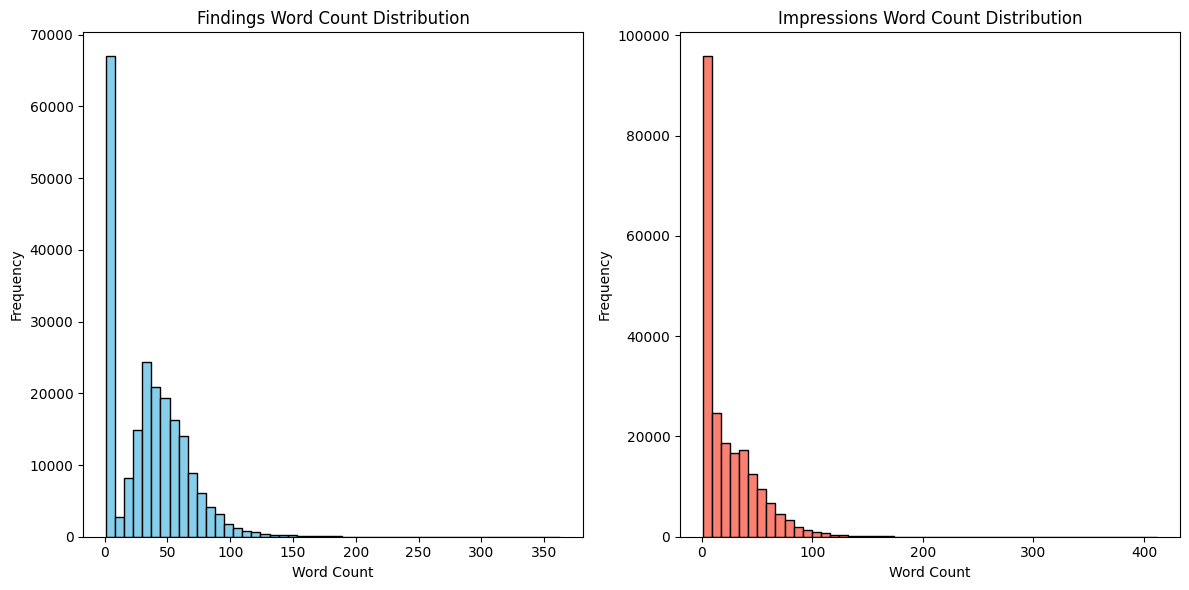

In [15]:
# Calculate word counts
grouped_df.loc[:,'findings_word_count'] = grouped_df['finding_sentences'].apply(lambda x: len(str(x).split()))
grouped_df.loc[:,'impressions_word_count'] = grouped_df['impression_sentences'].apply(lambda x: len(str(x).split()))

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(grouped_df['findings_word_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Findings Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(grouped_df['impressions_word_count'], bins=50, color='salmon', edgecolor='black')
plt.title('Impressions Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Calculate number of sentences
This can help determine if longer reports tend to have more sentences, which might indicate more complex cases.

Average number of sentences in findings: 3.7080447867451944
Median number of sentences in findings: 4.0
Average number of sentences in impressions: 2.3962295551836683
Median number of sentences in impressions: 2.0


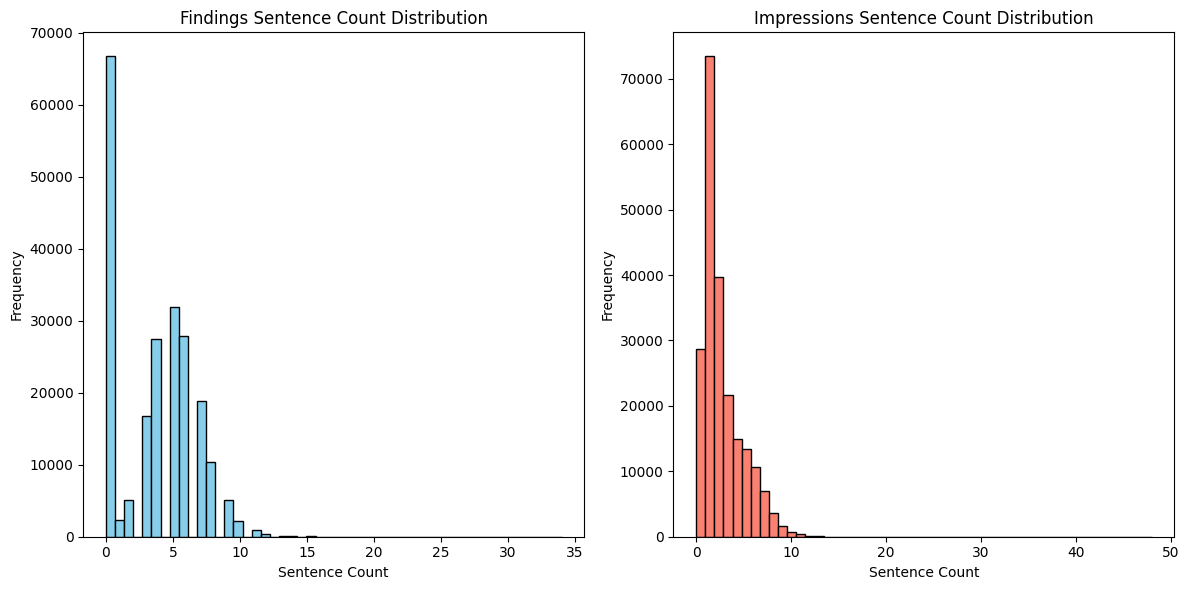

In [16]:
grouped_df.loc[:,'findings_sentence_count'] = grouped_df['finding_sentences'].apply(len)
grouped_df.loc[:,'impressions_sentence_count'] = grouped_df['impression_sentences'].apply(len)

# Calculate average and median
findings_avg_sentences = grouped_df['findings_sentence_count'].mean()
findings_median_sentences = grouped_df['findings_sentence_count'].median()

impressions_avg_sentences = grouped_df['impressions_sentence_count'].mean()
impressions_median_sentences = grouped_df['impressions_sentence_count'].median()

print(f"Average number of sentences in findings: {findings_avg_sentences}")
print(f"Median number of sentences in findings: {findings_median_sentences}")

print(f"Average number of sentences in impressions: {impressions_avg_sentences}")
print(f"Median number of sentences in impressions: {impressions_median_sentences}")

# Plot histograms
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.hist(grouped_df['findings_sentence_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Findings Sentence Count Distribution')
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
plt.hist(grouped_df['impressions_sentence_count'], bins=50, color='salmon', edgecolor='black')
plt.title('Impressions Sentence Count Distribution')
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Analyzing Image Distribution and Text-Image Correlation

Plotting the histogram of the number of images per patient provides insights into the dataset's structure, helping to identify typical cases and outliers. 

By plotting the relationship between word counts in findings and impressions against the number of images, we can explore potential correlations. This analysis helps determine if longer reports are associated with more images, which might indicate more complex cases or detailed documentation practices

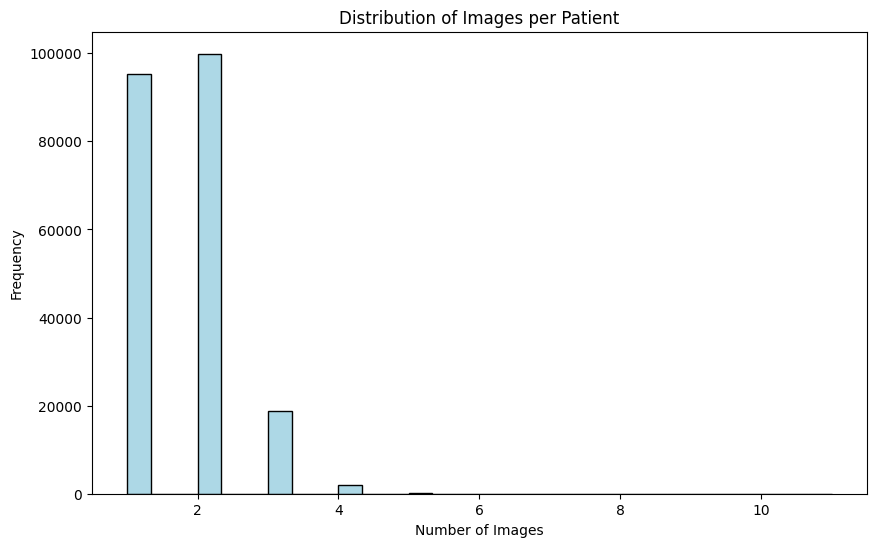

In [17]:
grouped_df['num_images'] = grouped_df['resized_image_files'].apply(len) 

# Plot histogram of images per patient
plt.figure(figsize=(10, 6))
plt.hist(grouped_df['num_images'], bins=30, color='lightblue', edgecolor='black')
plt.title('Distribution of Images per Patient')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.show()

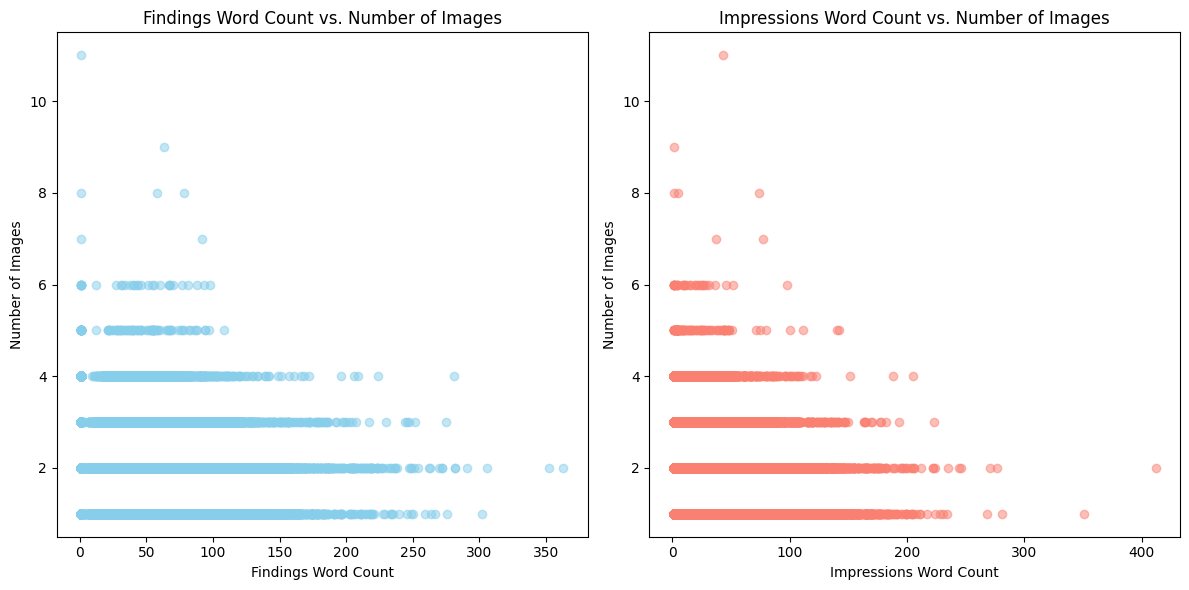

In [18]:
# Calculate word counts for findings and impressions against number of images
grouped_df['findings_word_count'] = grouped_df['finding_sentences'].apply(lambda x: len(str(x).split()))
grouped_df['impressions_word_count'] = grouped_df['impression_sentences'].apply(lambda x: len(str(x).split()))

# Plot relationship between findings word count and number of images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(grouped_df['findings_word_count'], grouped_df['num_images'], alpha=0.5, color='skyblue')
plt.title('Findings Word Count vs. Number of Images')
plt.xlabel('Findings Word Count')
plt.ylabel('Number of Images')

# Plot relationship between impressions word count and number of images
plt.subplot(1, 2, 2)
plt.scatter(grouped_df['impressions_word_count'], grouped_df['num_images'], alpha=0.5, color='salmon')
plt.title('Impressions Word Count vs. Number of Images')
plt.xlabel('Impressions Word Count')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

### Calculate word frequencies & plotting word clouds
Identifying the most common words in the findings and impressions can provide insights into the typical content of these reports and can inform us of which words are most important in these reports.

Word clouds can help visualize the most common words in the findings and impressions as well as identify any patterns or themes.

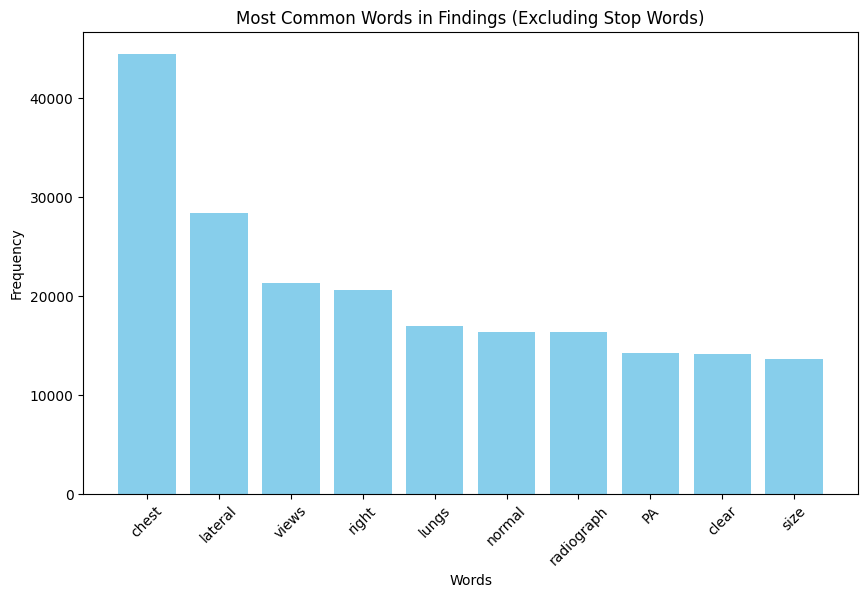

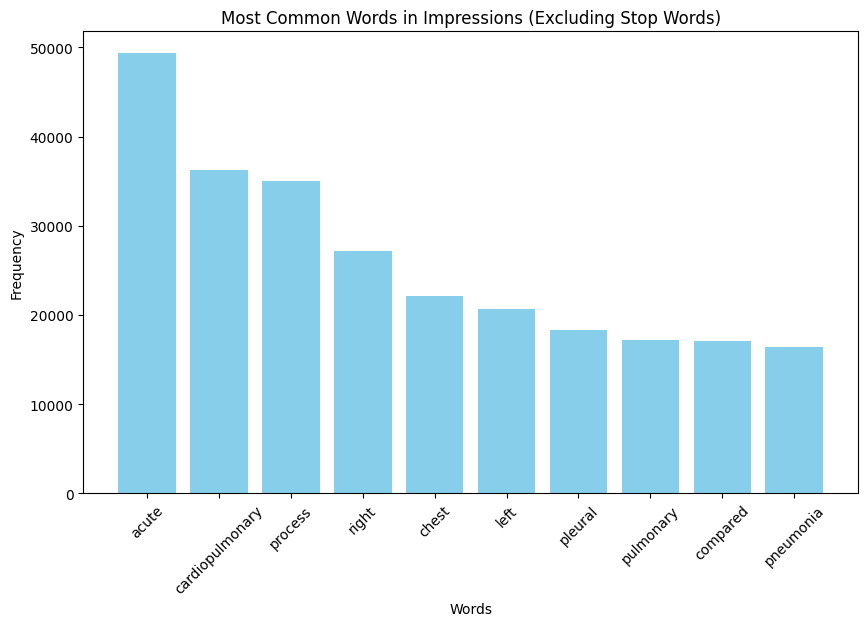

In [19]:
stopwords = set(STOPWORDS)
stopwords.update(['___', '___,', '1.', '___.', '___:', '1'])

def clean_text(text):
    # Remove punctuation using regex
    return re.sub(r'[^\w\s]', '', text)

# Function to calculate word frequencies excluding stop words
def calculate_word_frequencies(text_series):
    all_text = ' '.join(clean_text(text[0]) for text in text_series.fillna('') if text)
    word_counts = Counter(word for word in all_text.split() if word.lower() not in stopwords)
    return word_counts

# Calculate word frequencies for findings and impressions
findings_word_counts = calculate_word_frequencies(grouped_df['finding_sentences'])
impressions_word_counts = calculate_word_frequencies(grouped_df['impression_sentences'])

# Function to plot the top N most common words
def plot_most_common_words(word_counts, title, top_n=10):
    # Get the most common words and their counts
    most_common_words = word_counts.most_common(top_n)
    words, counts = zip(*most_common_words)
    # Plot the words and their frequencies
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Plot histograms for findings and impressions
plot_most_common_words(findings_word_counts, 'Most Common Words in Findings (Excluding Stop Words)')
plot_most_common_words(impressions_word_counts, 'Most Common Words in Impressions (Excluding Stop Words)')

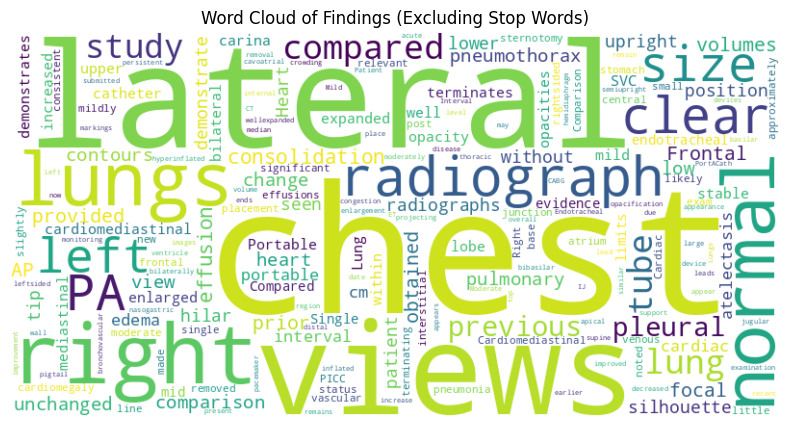

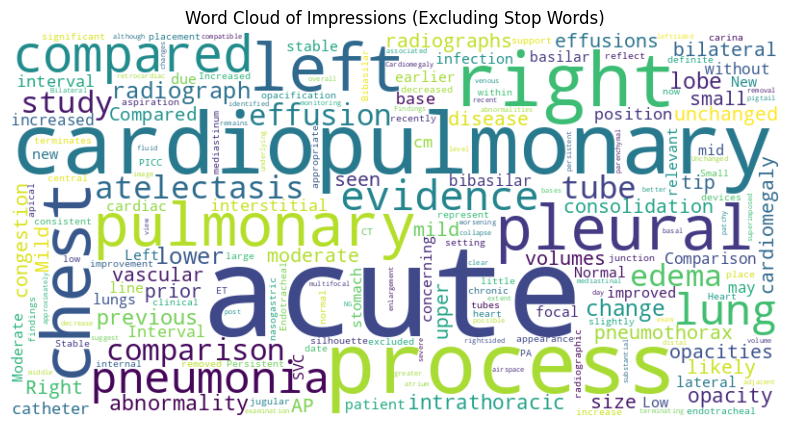

In [20]:
# Generate and plot word clouds
def plot_wordcloud(word_counts, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)    
    plt.show()

# Plot word clouds for findings and impressions
plot_wordcloud(findings_word_counts, 'Word Cloud of Findings (Excluding Stop Words)')
plot_wordcloud(impressions_word_counts, 'Word Cloud of Impressions (Excluding Stop Words)')